In [1]:
import gym
import math
import torch 
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.nn.utils import clip_grad_norm_
from collections import deque

!pip install box2d-py
!pip install gym[Box_2D]

     |████████████████████████████████| 450kB 4.8MB/s 


In [0]:
from multiprocessing import Process, Pipe
import numpy as np

def worker(remote, parent_remote, env_fn_wrapper):
    parent_remote.close()
    env = env_fn_wrapper.x()
    while True:
        cmd, data = remote.recv()
        if cmd == 'step':
            ob, reward, done, info = env.step(data)
            if done:
                ob = env.reset()
            remote.send((ob, reward, done, info))
        elif cmd == 'reset':
            ob = env.reset()
            remote.send(ob)
        elif cmd == 'reset_task':
            ob = env.reset_task()
            remote.send(ob)
        elif cmd == 'close':
            remote.close()
            break
        elif cmd == 'get_spaces':
            remote.send((env.observation_space, env.action_space))
        else:
            raise NotImplementedError

class CloudpickleWrapper(object):
    """
    Uses cloudpickle to serialize contents (otherwise multiprocessing tries to use pickle)
    """
    def __init__(self, x):
        self.x = x
    def __getstate__(self):
        import cloudpickle
        return cloudpickle.dumps(self.x)
    def __setstate__(self, ob):
        import pickle
        self.x = pickle.loads(ob)
        

class VecEnv(object):
    """
    An abstract asynchronous, vectorized environment.
    """
    def __init__(self, num_envs, observation_space, action_space):
        self.num_envs = num_envs
        self.observation_space = observation_space
        self.action_space = action_space

    def reset(self):
        """
        Reset all the environments and return an array of
        observations, or a tuple of observation arrays.
        If step_async is still doing work, that work will
        be cancelled and step_wait() should not be called
        until step_async() is invoked again.
        """
        pass

    def step_async(self, actions):
        """
        Tell all the environments to start taking a step
        with the given actions.
        Call step_wait() to get the results of the step.
        You should not call this if a step_async run is
        already pending.
        """
        pass

    def step_wait(self):
        """
        Wait for the step taken with step_async().
        Returns (obs, rews, dones, infos):
         - obs: an array of observations, or a tuple of
                arrays of observations.
         - rews: an array of rewards
         - dones: an array of "episode done" booleans
         - infos: a sequence of info objects
        """
        pass

    def close(self):
        """
        Clean up the environments' resources.
        """
        pass

    def step(self, actions):
        self.step_async(actions)
        return self.step_wait()

class SubprocVecEnv(VecEnv):
    def __init__(self, env_fns, spaces=None):
        """
        envs: list of gym environments to run in subprocesses
        """
        self.waiting = False
        self.closed = False
        nenvs = len(env_fns)
        self.nenvs = nenvs
        self.remotes, self.work_remotes = zip(*[Pipe() for _ in range(nenvs)])
        self.ps = [Process(target=worker, args=(work_remote, remote, CloudpickleWrapper(env_fn)))
            for (work_remote, remote, env_fn) in zip(self.work_remotes, self.remotes, env_fns)]
        for p in self.ps:
            p.daemon = True # if the main process crashes, we should not cause things to hang
            p.start()
        for remote in self.work_remotes:
            remote.close()

        self.remotes[0].send(('get_spaces', None))
        observation_space, action_space = self.remotes[0].recv()
        VecEnv.__init__(self, len(env_fns), observation_space, action_space)

    def step_async(self, actions):
        for remote, action in zip(self.remotes, actions):
            remote.send(('step', action))
        self.waiting = True

    def step_wait(self):
        results = [remote.recv() for remote in self.remotes]
        self.waiting = False
        obs, rews, dones, infos = zip(*results)
        return np.stack(obs), np.stack(rews), np.stack(dones), infos

    def reset(self):
        for remote in self.remotes:
            remote.send(('reset', None))
        return np.stack([remote.recv() for remote in self.remotes])

    def reset_task(self):
        for remote in self.remotes:
            remote.send(('reset_task', None))
        return np.stack([remote.recv() for remote in self.remotes])

    def close(self):
        if self.closed:
            return
        if self.waiting:
            for remote in self.remotes:            
                remote.recv()
        for remote in self.remotes:
            remote.send(('close', None))
        for p in self.ps:
            p.join()
            self.closed = True
            
    def __len__(self):
        return self.nenvs

In [0]:
class Critic(nn.Module):
    def __init__(self, input_shape, hidden_size):
        super(Critic, self).__init__()
        self.net = nn.Sequential(nn.Linear(input_shape, hidden_size),
                                 nn.ReLU(),
                                 nn.Linear(hidden_size,hidden_size),
                                 nn.ReLU(),
                                 nn.Linear(hidden_size, 1))
    
    def forward(self,x):
        x = self.net(x)
        return x
      
class Actor(nn.Module):
    def __init__(self, input_shape, output_shape, hidden_size):
        super(Actor, self).__init__()
        self.net = nn.Sequential(nn.Linear(input_shape, hidden_size),
                                 nn.Tanh(),
                                 nn.Linear(hidden_size,hidden_size),
                                 nn.Tanh())
        self.mean = nn.Linear(hidden_size, output_shape)
        self.variance = nn.Linear(hidden_size, output_shape)
        

    def forward(self, x):
        
        head = self.net(x)
        mean = F.tanh(self.mean(head)) # tanh squashed output to the range of -1..1
        variance = F.softplus(self.variance(head)) # log(1 + e^x) has the shape of a smoothed ReLU
        sigma = torch.sqrt(variance.cpu())
        m = Normal(mean.cpu(), sigma)
        actions = m.sample()
        actions = torch.clamp(actions, -1, 1) # usually clipping between -1,1 but pendulum env has action range of -2,2

        logprobs = m.log_prob(actions) #for the optimization step we create a new distribution based on the new mean and variance - still taking the logprobs based on the old actions!

    
        return actions, logprobs, m
    

    


In [0]:
class Agent():
  def __init__(self,
               state_size,
               action_size,
               hidden_size,
               LR_A=1e-4,
               LR_C=1e-4,
               gamma=0.99,
               lambda_=0.95,
               mini_batch_size=512,
               ppo_epochs=5):
    
    
    self.actor = Actor(state_size, action_size, hidden_size).to(device)
    self.critic = Critic(state_size, hidden_size).to(device)
    
    self.gamma = gamma
    self.lambda_ = lambda_
    self.mini_batch_size = mini_batch_size
    self.ppo_epochs = ppo_epochs
    

    self.optimizer_a = optim.RMSprop(params=self.actor.parameters(), lr=LR_A)
    self.optimizer_c = optim.RMSprop(params=self.critic.parameters(), lr=LR_C)
       

  def test_net(self, count = 10):
      """
      Tests the agents performance with current weights.
      """
      rewards = 0.0
      steps = 0
      entropys = 0.0
      for _ in range(count):
          obs = env.reset()

          while True:
              obs_v = torch.from_numpy(obs).unsqueeze(0).float()
              action, _, dist = self.actor(obs_v.to(device))
              entropy = dist.entropy().detach().cpu().numpy()
              obs, reward, done, info = env.step(action[0].cpu().numpy())

              rewards += reward
              entropys += entropy.mean()
              steps += 1
              if done:
                  break

      return rewards/count, entropys/count, steps/count




  def compute_gae(self, next_value, rewards, masks, values):
      """
      lambda => 1: high variance, low bias
      lambda => 0: low variance, high bias
      """

      rewards_batch = list(zip(*rewards))
      masks_batch = list(zip(*masks))
      values_batch = torch.cat((torch.stack(values, dim=1).squeeze(2), next_value.squeeze(0)),dim=1)
      
      out_discounted_rewards = []
      out_advantage = []
      for rewards, masks, values  in zip(rewards_batch, masks_batch, values_batch):
      
        gae = 0
        disc_returns = []
        advantage = []
        for step in reversed(range(len(rewards))):
            # d = r_t +gamma*V(s_t+1) - V(s)
            delta = rewards[step] + self.gamma * values[step + 1] * masks[step] - values[step]
            # sum(lambda*gamma)^t* delta_t+1
            gae = delta + self.gamma * self.lambda_ * masks[step] * gae

            disc_returns.insert(0, gae + values[step]) # adding values since we want the returns and not the advantage yet!  A(a,s) = Q"returns" - V(s)
            advantage.insert(0, gae)
            
        out_discounted_rewards.append(disc_returns)
        out_advantage.append(advantage)
        
      return torch.FloatTensor(out_discounted_rewards).flatten().unsqueeze(1), torch.FloatTensor(out_advantage).flatten().unsqueeze(1)


  def ppo_iter(self, states, actions, log_probs, advantage, discounted_rewards):
      batch_size = len(states)

      for i in range(batch_size // self.mini_batch_size):
          rand_ids = np.random.randint(0, batch_size, self.mini_batch_size)

          yield states[rand_ids], actions[rand_ids], log_probs[rand_ids], advantage[rand_ids], discounted_rewards[rand_ids]



  def ppo_update(self, states, actions, log_probs, advantage, discounted_rewards, eps_clip=0.2):
    """

    """

    a_loss_batch = []
    c_loss_batch = []


    for _ in range(self.ppo_epochs):
      for states_i, old_actions, old_logprobs, advantage_i, discounted_reward_i  in self.ppo_iter(states, actions, log_probs, advantage, discounted_rewards):

        self.optimizer_c.zero_grad()
        self.optimizer_a.zero_grad()

        #train critic
        new_value = self.critic(states_i.to(device))
        c_loss = .5 * F.mse_loss(new_value, discounted_reward_i)
        c_loss.backward()
        clip_grad_norm_(self.critic.parameters(),CLIP_GRAD)
        self.optimizer_c.step()

        #train actor
        _, _, dist = self.actor(states_i.to(device))
        new_logprobs = dist.log_prob(old_actions)
        entropy = dist.entropy().mean()

        ratio = torch.exp(new_logprobs - old_logprobs.detach())
        surr = ratio * advantage_i
        clip = torch.clamp(ratio, 1.0 - eps_clip, 1.0 + eps_clip) 
        a_loss  = - (torch.min(surr, clip*advantage_i).mean()) + ENTROPY_BONUS * entropy
        a_loss.backward(retain_graph=True)
        clip_grad_norm_(self.critic.parameters(),CLIP_GRAD)
        self.optimizer_a.step()
        
        c_loss_batch.append(c_loss.detach().numpy())
        a_loss_batch.append(a_loss.detach().numpy())      



    return np.array(c_loss_batch).mean(), np.array(a_loss_batch).mean()

Using:  cpu


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1374: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode: 350 | Ep_Reward: 46.05 | Average_100: -1.37

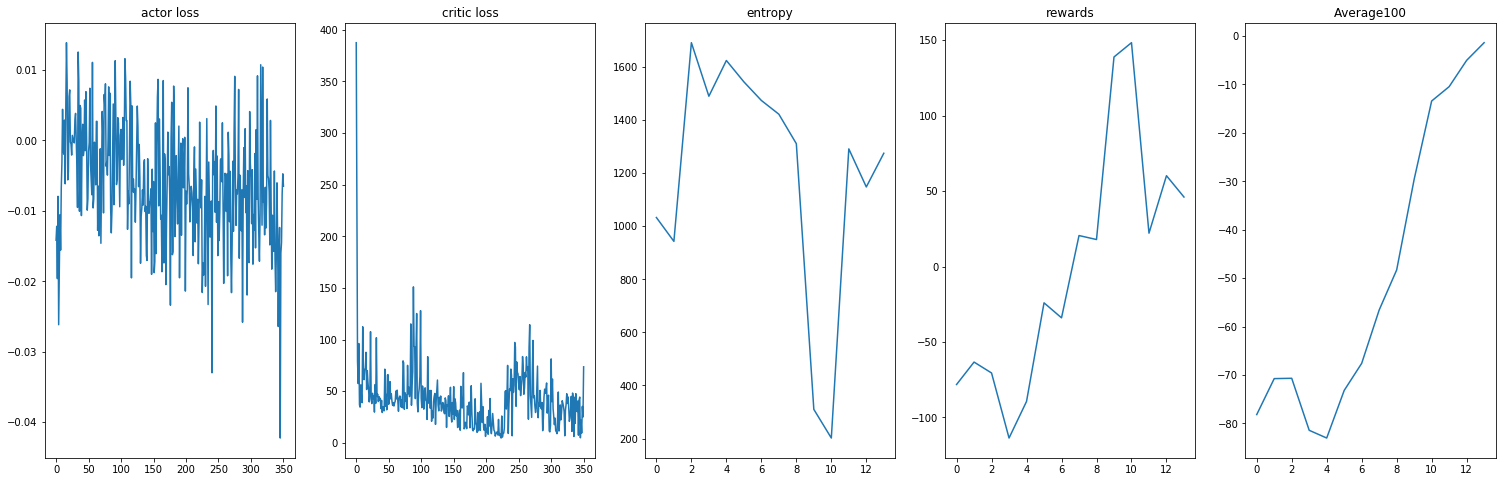

In [18]:
ENV = "LunarLanderContinuous-v2" #"MountainCarContinuous-v0"  #Pendulum-v0 LunarLanderContinuous-v0

env = gym.make(ENV)#Creating the Environment

n_cpu = 6

envs = SubprocVecEnv([lambda: gym.make(ENV) for i in range(n_cpu)])

torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)
#env.seed(42)



device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using: ", device)

GAMMA = 0.99
ENTROPY_BONUS = 0.00001
LAMBDA = 0.95
CLIP_GRAD = .25


state_size  = env.observation_space.shape[0]
action_size = env.action_space.shape[0]

agent = Agent(state_size, action_size, hidden_size=64, LR_A=5e-4, LR_C=5e-4)

max_episodes = 350


c_loss_list = []
a_loss_list = []
entropy_list = []


average_100 = []
plot_rewards = []
max_steps = 1024

# calc reshape stacking size
shape = (max_steps*n_cpu, state_size)

for ep in range(max_episodes+1):
    states = envs.reset()

    done = False
    
    state_batch = []
    value_batch = []
    action_batch = []
    logprob_batch = []
    rewards_batch = []
    masks = []
    for step in range(max_steps):

        states = torch.from_numpy(states).float()
        action, logprob, _  = agent.actor(states.to(device))  
        value = agent.critic(states.to(device))
        next_states, reward, done, _ = envs.step(action.cpu().numpy())
        
        state_batch.append(states)
        value_batch.append(value)
        logprob_batch.append(logprob)
        action_batch.append(action)
        rewards_batch.append(torch.from_numpy(reward).float())  
        masks.append(torch.from_numpy(1 - done).float())

        states = next_states

        if np.any(done):
          states = envs.reset()
    
    # stack all gathered data
    
    state_batch = torch.stack(state_batch,dim=1).reshape(shape)
    actions_batch = torch.stack(action_batch, dim=1).reshape(max_steps*n_cpu,action_size)
    logprob_batch = torch.stack(logprob_batch, dim=1).reshape(max_steps*n_cpu,action_size)    
    #rewards_batch = rewards.reshape(n_cpu, max_steps) # reshapes into environment format  (num_env,X)


    # calculate advantage:
    next_value = agent.critic(torch.from_numpy(next_states).unsqueeze(0).float())
    discounted_rewards, advantage = agent.compute_gae(next_value, rewards_batch, masks, value_batch)

    # normalize advantage:
    advantage = (advantage - advantage.mean()) / (advantage.std() + 1e-5)
    
    c_loss, a_loss = agent.ppo_update(states=state_batch, actions=actions_batch, log_probs=logprob_batch, advantage=advantage, discounted_rewards=discounted_rewards)
    c_loss_list.append(c_loss)
    a_loss_list.append(a_loss)

    
    
    if ep != 0 and ep % 25 == 0:
      test_rewards, test_entropy, test_steps = agent.test_net()
      entropy_list.append(test_entropy)
      plot_rewards.append(test_rewards)

      average_100.append(np.mean(plot_rewards[-100:]))
      print("\rEpisode: {} | Ep_Reward: {:.2f} | Average_100: {:.2f}".format(ep, test_rewards, np.mean(plot_rewards[-100:])), end = "", flush = True)
        
        

    

# PLOTTING RESULTS

plt.figure(figsize = (26,8))
plt.subplot(1,5,1)
plt.title("actor loss")
plt.plot(a_loss_list)
plt.subplot(1,5,2)
plt.title("critic loss")
plt.plot(c_loss_list)
plt.subplot(1,5,3)
plt.title("entropy")
plt.plot(entropy_list)
plt.subplot(1,5,4)
plt.title("rewards")
plt.plot(plot_rewards)
plt.subplot(1,5,5)
plt.title("Average100")
plt.plot(average_100)
plt.show()